### Посмотрим на данные

In [1]:
from PIL import Image

In [2]:
orig_img = Image.open("./dataset_sample/original_images_test/000.jpg")
#orig_img

In [3]:
#mask_img = Image.open("./dataset_sample/label_images_rgb/000.png")
#mask_img

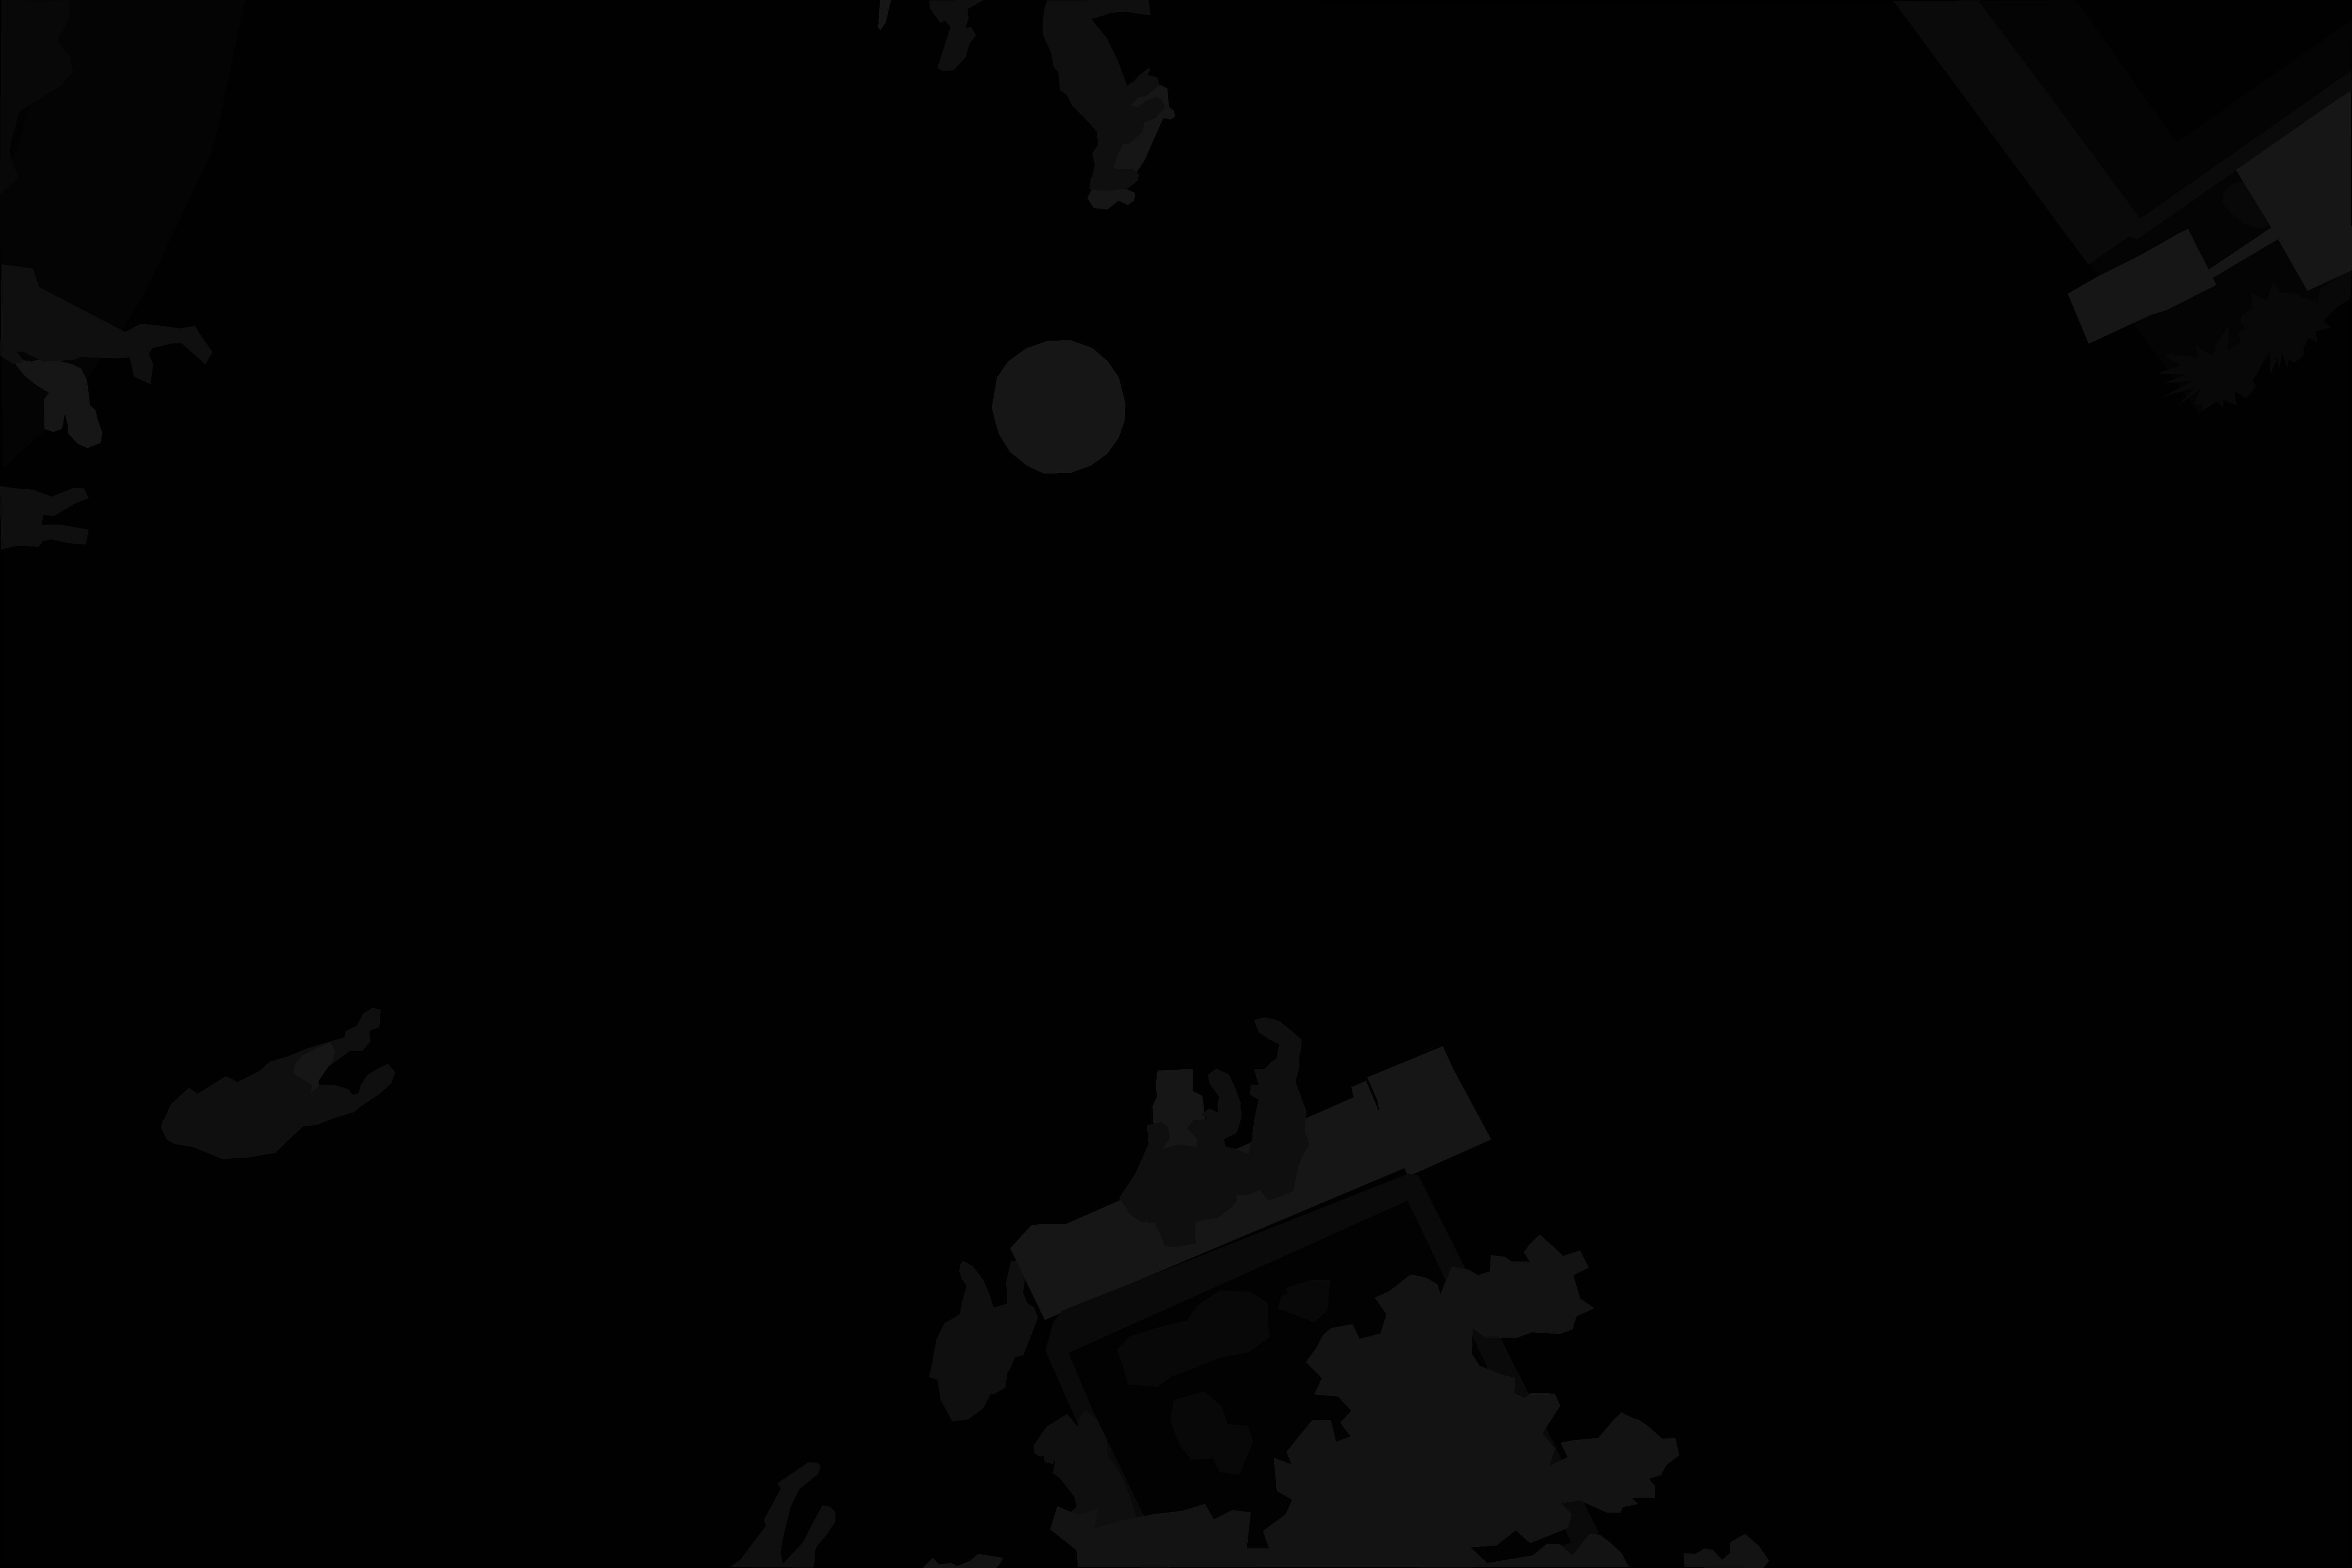

In [4]:
mask_img = Image.open("./dataset_sample/label_images_semantic_test/000.png")
mask_img

In [5]:
import numpy as np
mask_img_arr = np.array(mask_img)
mask_img_arr.shape

(4000, 6000)

In [6]:
np.unique(mask_img_arr)

array([ 0,  1,  2,  4,  8, 10, 15, 19, 22], dtype=uint8)

In [7]:
#pip install torch

In [8]:
#pip install segmentation-models-pytorch

### Создадим датасет

In [9]:
from torch.utils.data import Dataset, DataLoader
import os
import cv2
import torch
from torchvision import datasets, transforms

class SegmentationDataset(Dataset):
  
    def __init__(self, imgs_dir, masks_dir, transform=None, transform_mask=None):
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.transform_mask = transform_mask
        
        self.imgs_paths = os.listdir(self.imgs_dir)
        self.imgs_paths.sort()
        
        self.masks_paths = os.listdir(self.masks_dir)
        self.masks_paths.sort()
        
    def __len__(self):
        return len(self.imgs_paths)
    
    def __getitem__(self, idx):
        img = cv2.imread(os.path.join(self.imgs_dir, self.imgs_paths[idx]))
        # TODO: Изменить размер изображения, используя Pytorch Transformations, вынести размер изображения как параметр

        if self.transform:
            img = self.transform(img).float()
        #img = cv2.resize(img, (512, 512))
        print(type(img))
        # TODO: Перевести в тензор, используя Pytorch Transformations
        #img = torch.from_numpy(img).float()
        # TODO: Добавить нормировку изображения, используя Pytorch Transformations

        # TODO: Добавить аугментацию

        #print(img.shape)
        # Меняем размерность с (ширина x высота x количество каналов) на (количество каналов х ширина х высота)
        #img = img.permute(2, 0, 1)
        
        mask = cv2.imread(os.path.join(self.masks_dir, self.masks_paths[idx]), cv2.IMREAD_GRAYSCALE)
        # TODO: Аналогично совершить эти преобразования, используя Pytorch Transformations
        if self.transform_mask:
            mask =  torch.squeeze(self.transform_mask(mask)).long()
        #mask = cv2.resize(mask, (512, 512))
        #mask = torch.from_numpy(mask).long()
        
        return img, mask

In [10]:
transform = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(512),
                                 transforms.CenterCrop(512),
                                 transforms.Normalize([0, 0, 0], [1, 1, 1])
                                 ])

transform_mask = transforms.Compose([transforms.ToTensor(),
                                 transforms.Resize(512),
                                 transforms.CenterCrop(512),
                                 transforms.Normalize([0], [1])
                                 ])

In [11]:
train_dataset = SegmentationDataset("./dataset_sample/original_images/", "./dataset_sample/label_images_semantic/", transform, transform_mask)

In [12]:
train_dataset.__getitem__(1)[1].shape

<class 'torch.Tensor'>


torch.Size([512, 512])

In [13]:
# TODO: Отдельный датасет на validation set
train_size = int(0.8 * len(train_dataset))
test_size = len(train_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, test_size])

In [14]:
len(train_dataset), len(test_dataset)

(6, 2)

In [15]:
img, mask = next(iter(train_dataset))

<class 'torch.Tensor'>


In [16]:
img.shape, img.dtype

(torch.Size([3, 512, 512]), torch.float32)

In [17]:
mask.shape, mask.dtype

(torch.Size([512, 512]), torch.int64)

In [18]:
# TODO: Поиграться с размером батча
batch_size= 5

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# TODO: Отдельный loader на validation set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Создадим модель

In [19]:
import segmentation_models_pytorch as smp

#Сравнить с весами с imagenet и без
model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23)

In [20]:
model

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride

In [21]:
from torch import nn
# TODO: Заменить голову на свою
model.segmentation_head = nn.Sequential(
    nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
    nn.Conv2d(32, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [22]:
model.segmentation_head

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): Conv2d(32, 23, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [23]:
# TODO: Поиграться с заморозкой весов
for param in model.encoder.parameters():
    param.requires_grad = False

In [24]:
img_batch, mask_batch = next(iter(train_loader))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [25]:
img_batch.shape

torch.Size([5, 3, 512, 512])

In [26]:
mask_batch.size(0)

5

In [27]:
output_batch = model(img_batch)

In [28]:
_,predicted = output_batch.max(1)

In [29]:
predicted.shape

torch.Size([5, 512, 512])

In [30]:
a=torch.tensor([[[1, 2], [3, 4]],[[1, 2], [3, 4]]])
b=torch.tensor([[[1, 1], [4, 4]],[[1, 1], [4, 4]]])

In [31]:
a.size(0)*a.size(1)*a.size(2)

8

In [32]:
b

tensor([[[1, 1],
         [4, 4]],

        [[1, 1],
         [4, 4]]])

In [33]:
torch.eq(a,b).sum().item()

4

In [34]:
output_batch.shape

torch.Size([5, 23, 512, 512])

In [35]:
total = 0
correct = 0

_,predicted = output_batch.max(1)
total += torch.numel(mask_batch)
correct += predicted.eq(mask_batch).sum().item()

In [36]:
total, correct

(1310720, 72015)

In [37]:
a = torch.randn(4, 4)

In [38]:
a

tensor([[ 0.9471,  1.3603, -0.8739,  1.1712],
        [-0.1848,  0.1558,  0.4154, -0.5426],
        [-0.9437,  0.2347, -0.8987, -0.5299],
        [-0.0246, -0.5267, -1.4370,  2.5214]])

In [39]:
predicted.shape

torch.Size([5, 512, 512])

In [40]:
from torch.nn import CrossEntropyLoss

CrossEntropyLoss()(output_batch, mask_batch) 

tensor(3.0597, grad_fn=<NllLoss2DBackward>)

### Обучение

In [41]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Using device:', device)

Using device: cuda


In [42]:
model.to(device)

Unet(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 1), stride

In [43]:
epoch_count = 5

loss = CrossEntropyLoss()

In [44]:
# TODO: поиграться с learning rate
learning_rate = 0.01

# TODO поиграться с выбором алгоритма в целом
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [53]:
from tqdm import tqdm
import torch
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

train_loss = test_loss = total_test=total_train=correct_test=correct_train=running_loss=running_loss_test=0
train_losses =test_losses=train_accu=test_accu= []
for epoch_num in range(epoch_count):
    for batch_num, (img_batch, mask_batch) in enumerate(tqdm(train_loader)):

        img_batch = img_batch.to(device) 
        mask_batch = mask_batch.to(device)
    
        optimizer.zero_grad()
        output_batch = model(img_batch)
        loss_value = loss(output_batch, mask_batch)
        #writer.add_scalar("Loss/train", loss_value, epoch_num)

        loss_value.backward()
        optimizer.step()

        #pixelAccuracy
        running_loss += loss_value.item()
        _,predicted_train = output_batch.max(1)
        correct_train += predicted_train.eq(mask_batch).sum().item()  
    total_train = torch.numel(mask_batch)
    accu_train=100.*correct_train/total_train
    train_accu.append(accu_train)
    train_loss=running_loss/len(train_loader) 
    train_losses.append(train_loss)     
     
        # TODO: Добавить вычисление метрики, исходя из значений output_batch и mask_batch
        # Варианта метрик: IoU, попиксельная Accuracy
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu_train))
    #print(f"Epoch {epoch_num} / {epoch_count} | train loss = {train_loss}")  

    model.eval()
    with torch.no_grad():
        for batch_num, (img_batch, mask_batch) in enumerate(tqdm(test_loader)):
            img_batch = img_batch.to(device) 
            mask_batch = mask_batch.to(device)

            output_batch = model(img_batch)
            loss_value_test = loss(output_batch, mask_batch)
            running_loss_test+=loss_value_test.item()

            #pixelAccuracy
            _,predicted_test = output_batch.max(1)
            correct_test += predicted_test.eq(mask_batch).sum().item()  
    total_test = torch.numel(mask_batch)
    accu_test=100.*correct_test/total_test
    test_accu.append(accu_test)
            
    test_loss=running_loss_test/len(test_loader)
    test_losses.append(test_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(test_loss,accu_test))
    #print(f"Epoch {epoch_num} / {epoch_count} | test loss = {test_loss}")  

#writer.flush()
        
    # TODO: Добавить расчет метрик и лосса на валидации и их логирование
    # print(f"Epoch {epoch_num} / {epoch_count} | val Loss = {val_loss} | val accuracy = {val_accuracy}")

    # TODO: Сохранять лучшую модель по метрикам на валидации
    
    # TODO: Добавить early stopping: если модель на валидации не улучшается некоторое 
    # количество эпох, то прекратить обучение

  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 1/2 [00:05<00:05,  5.17s/it]

<class 'torch.Tensor'>


100%|██████████| 2/2 [00:06<00:00,  3.09s/it]


Train Loss: 0.000 | Accuracy: 600.000


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


Train Loss: 0.000 | Accuracy: 100.000


  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 1/2 [00:05<00:05,  5.12s/it]

<class 'torch.Tensor'>


100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


Train Loss: 0.000 | Accuracy: 1200.000


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


Train Loss: 0.000 | Accuracy: 200.000


  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 1/2 [00:04<00:04,  4.96s/it]

<class 'torch.Tensor'>


100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


Train Loss: 0.000 | Accuracy: 1800.000


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Train Loss: 0.000 | Accuracy: 300.000


  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 1/2 [00:04<00:04,  4.99s/it]

<class 'torch.Tensor'>


100%|██████████| 2/2 [00:05<00:00,  3.00s/it]


Train Loss: 0.000 | Accuracy: 2400.000


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 1/1 [00:01<00:00,  1.86s/it]


Train Loss: 0.000 | Accuracy: 400.000


  0%|          | 0/2 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


 50%|█████     | 1/2 [00:04<00:04,  4.99s/it]

<class 'torch.Tensor'>


100%|██████████| 2/2 [00:06<00:00,  3.01s/it]


Train Loss: 0.000 | Accuracy: 3000.000


  0%|          | 0/1 [00:00<?, ?it/s]

<class 'torch.Tensor'>
<class 'torch.Tensor'>


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]

Train Loss: 0.000 | Accuracy: 500.000


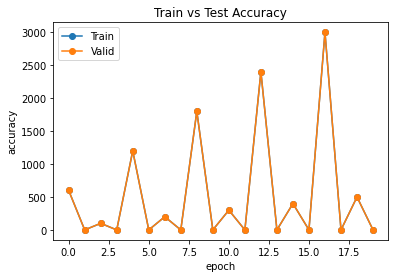

In [54]:
import matplotlib.pyplot as plt

plt.plot(train_accu,'-o')
plt.plot(test_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Test Accuracy')
 
plt.show()

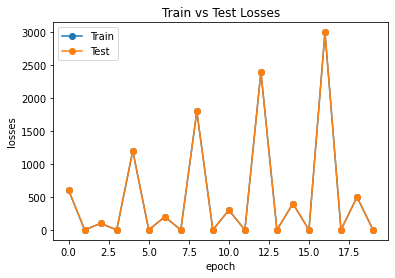

In [55]:
plt.plot(train_losses,'-o')
plt.plot(test_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [47]:
# TODO: Нарисовать графики изменения лосса на трейне/валидации в зависимсоти от эпох и аналогичный график по метрикам